<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset de dados de confiabilidade: https://drive.google.com/drive/folders/1b7jqK1A2XI1oZ4YhDXw_4xdnSTbfuBVK?usp=sharing

In [252]:
%%capture
pip install pyswarms

In [253]:
import numpy as np
import pandas as pd
import math
import csv
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [254]:
MAX_VALUE_CUSTO = 10000
fator_melhoria = 'expo'
DIAS_OBSERVADOS = 600

In [255]:
# Custos MC e MP
CMC = 4000
CMP = 2000

In [256]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [257]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [258]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [302]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m):
        linha = []
        # Verifique se o índice k é válido
        if k >= len(s):
            break
        for j in range(0, ck):
            # Verifique se o índice j é válido
            if j >= len(s[k]):
                break
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)

    return fator

In [260]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [261]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [303]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [263]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

In [317]:
# Defina o dicionário de tipos de dados
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
# df = pd.read_csv('/content/drive/MyDrive/datasets/cenario01.csv.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/cenario02.csv.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/cenario03.csv.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/cenario04.csv.csv', sep=";")
df = pd.read_csv('/content/drive/MyDrive/datasets/cenario01.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,150.0
1,110,1,1,0.0,0.5,250.0
2,125,1,1,9.0,0.9,500.0
3,135,1,1,2.0,0.2,600.0
4,295,1,3,2.0,0.4,0.0


In [318]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

In [340]:
def objective(x):
    lamb = x[0]
    beta = x[1]
    theta = x[2]

    # Cria fator de melhoria
    fator = execute_function(fator_melhoria, ck, m, s, theta)

    cont = 0
    fitness = 1

    for k in range(m):
        prod = 1
        for j in range(ck):
            if j < len(T):
                T_value = T[j]
            else:
                T_value = 0

            if k < len(fator) and j < len(fator[k]):
                fator_value = fator[k][j]
            else:
                fator_value = 0

            if k < len(n) and j < len(n[k]):
                nkj = int(n[k][j])
                for i in range(nkj):
                    if cont < len(t):
                        t_value = int(t[cont])
                    else:
                        t_value = 0

                    if (lamb == 0).any():
                        # Evite divisão por zero
                        lamb[lamb == 0] = 1e-10


                    if (beta == 0).any():
                        # Evite exponenciação que pode resultar em estouro numérico
                        beta[beta == 0] = 1e-10

                    # Evite exponenciações que podem resultar em estouro numérico
                    if (beta == 1).any():
                        prod *= (t_value - fator_value * T_value) ** (beta - 1)
                    else:
                        prod *= (1 / (lamb ** beta)) * beta * ((t_value - fator_value * T_value) ** (beta - 1))
                    cont += 1

        soma = 0
        for l in range(ck):
            if l < len(T) and l + 1 < len(T):
                T_l_value = T[l]
                T_lplus1_value = T[l + 1]
            else:
                T_l_value = 0
                T_lplus1_value = 0

            if (lamb == 0).any():
                # Evite divisão por zero
                lamb = np.maximum(1e-10, lamb)

            if (beta == 0).any():
                # Evite exponenciações que podem resultar em estouro numérico
                beta = np.maximum(1e-10, beta)

            if np.allclose(beta, 1, atol=1e-10):
                # Evite exponenciações que podem resultar em estouro numérico
                beta = np.maximum(1e-10, beta)

                soma += ((T_lplus1_value - fator[k][l] * T_l_value) ** beta - (T_l_value - fator[k][l] * T_l_value) ** beta)
            else:
                soma += ((1 / (lamb ** beta)) * (T_lplus1_value - fator[k][l] * T_l_value) ** beta - (1 / (lamb ** beta)) * (T_l_value - fator[k][l] * T_l_value) ** beta)

        ans = np.exp(-soma)
        fitness *= prod * ans

    return -fitness


In [ ]:
print('lambda: ', lamb)
print('beta: ', beta)
print('theta: ', theta)
print('')
print('n: ', n)
print('')
print('t: ', t)
print('')
print('ck: ', ck)
print('s: ', s)
print('')
print('T: ', T)
print('fator: ', fator)

In [344]:
# Parâmetros do PSO
num_particles = 100
max_iterations = 50
dimensions = 3
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

# Limites inferiores e superiores para lamb, beta e theta
lb = np.array([100, 1, 0])
ub = np.array([150, 2, 1])
bounds = (lb, ub)

# Configuração do PSO
optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores apropriados
optimizer.swarm.current_cost = np.full(num_particles, np.inf)
optimizer.swarm.pbest_cost = np.full(num_particles, np.inf)

# Executa a otimização
# cost, pos = optimizer.optimize(objective, iters=max_iterations)

# Recupere os valores ótimos
# lamb_optimal, beta_optimal, theta_optimal = pos

# # Resultados
# print("Resultado da otimização:")
# print(f"lambda: {lamb_optimal}")
# print(f"beta: {beta_optimal}")
# print(f"theta: {theta_optimal}")

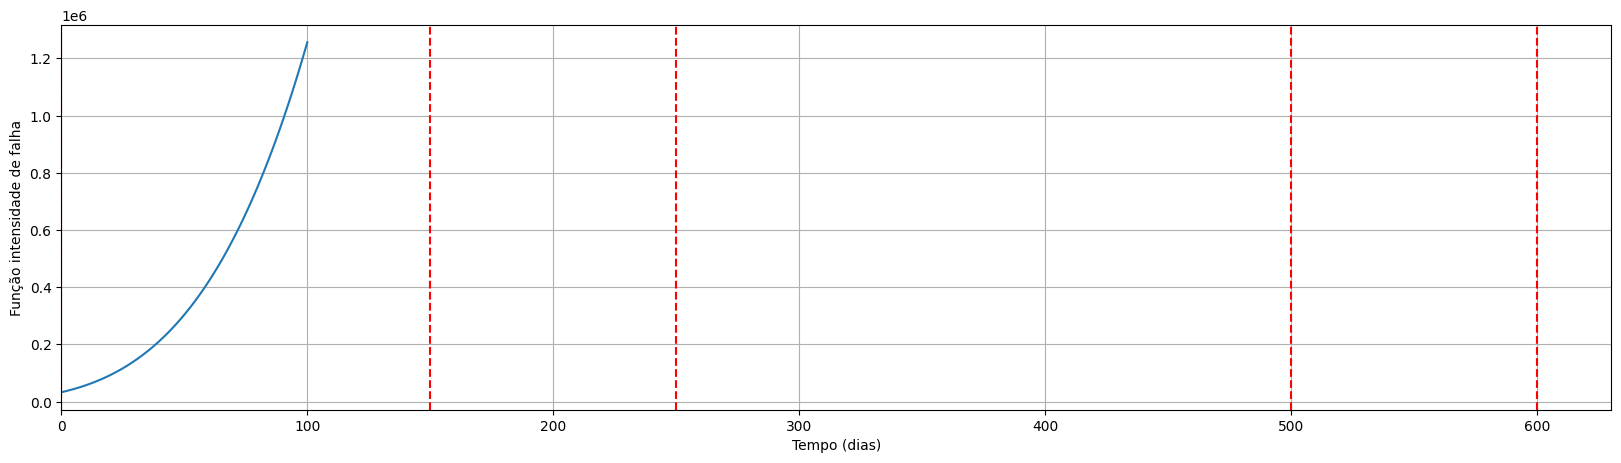

Fator ajuste:  [0.5506710358827784, 0.6321205588285577, 0.8347011117784134, 0.3296799539643607]


In [346]:
# Criação de variáveis para os parâmetros
lamb = 5
beta = 5
theta = 2

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [347]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo


    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [348]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

pbest_cost = optimizer.swarm.pbest_cost

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-10-02 01:29:09,654 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   8%|▊         |8/100, best_cost=5.44e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 1, 88, 112, 327, 348, 455, 481, 597, 643, 680, 715]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.75, 0.25, 0.75, 0.25, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 0.00032, 1657345.060504935, 1828154.8253047196, 581536189.5731088, 645767617.0130042, 713553473.434081, 1004804707.5058985, 1178011336.985845, 2808263954.7667418, 3061396263.2389708, 4981212955.5031395, 4601051791.551203]
Custo =  478196442527.3779


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 59, 68, 201, 380, 400, 443, 466, 490, 514, 548, 684]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.75, 0.5, 0.25, 0.75, 0.25, 0.75, 0.25, 0.5]


pyswarms.single.global_best:  29%|██▉       |29/100, best_cost=5.23e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 24, 86, 124, 203, 237, 293, 372, 406, 449, 483, 527, 578, 631, 712]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2548.0396800000003, 931303.5192117589, 2714332.5509436573, 29851066.038171194, 33959418.05907886, 116074692.54476957, 184180340.6105939, 215404599.436781, 573570322.822065, 634536112.7657402, 1334027567.4408078, 1528122664.203502, 1580551810.606691, 1734602376.5550435, 1364318127.5191748]
Custo =  159184840746.52527


Número de ciclos de manutenção: 13 5
Tempos para manutenções prevent

pyswarms.single.global_best:  49%|████▉     |49/100, best_cost=5.15e+10

Custo =  93145481018.68245


Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 26, 32, 77, 219, 250, 298, 321, 365, 476, 482, 524, 542, 593, 619, 630, 719]
Severidade para cada subsistema: [0.25, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 3802.0403200000005, 5546.175938080017, 359381.8937781012, 33063320.935225643, 57598702.39388253, 72684944.37961562, 80749742.67147641, 86759628.02582072, 356861281.4320461, 358228932.0297829, 464510820.5956142, 512432702.8712253, 552237403.0253787, 671753739.0787823, 679263310.3635746, 1551901576.1714

pyswarms.single.global_best:  59%|█████▉    |59/100, best_cost=5.15e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 41, 82, 93, 148, 217, 241, 319, 475, 487, 519, 593, 634, 716]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 37073.98432, 514079.52933163167, 520329.6054633249, 5829448.806845758, 14849903.888295447, 31414573.479820356, 70804382.4466846, 263855830.15830693, 284391121.0249012, 359659456.5616252, 696106205.4423404, 733171253.1441203, 893358733.9807954, 509890562.4993592]
Custo =  69785393202.89264


Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 38, 77, 90, 157, 219, 317, 390, 474, 486, 521, 594

pyswarms.single.global_best:  77%|███████▋  |77/100, best_cost=5.15e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 29, 51, 79, 92, 180, 220, 241, 272, 321, 470, 493, 518, 592, 632, 717]
Severidade para cada subsistema: [0.25, 0.75, 0.25, 0.5, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 6563.56768, 44778.373212634746, 263196.49590115255, 271275.57053825597, 19775058.885351375, 23694240.519003548, 26104596.27903815, 32201785.1235511, 37020027.83654018, 203688123.83627033, 246571528.5070398, 303542203.9754926, 637876529.7175606, 673309554.8179802, 844205732.781527, 457422915.14042974]
Custo =  66887722481.66699


Número de ciclos de manutençã

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=5.15e+10
2023-10-02 01:29:10,920 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51475801566.93451, best pos: [2.27247576 4.63059016 0.34137857 3.11831533 1.97487105 1.45529354
 6.21701673 3.56828533 2.60204075 2.53359235 3.17959548 4.81117552
 0.29102383 5.42691384 2.38245302 3.67163462 3.50505261 5.28399473
 6.04124622 5.818495   2.98497557 3.17205507 2.26591892 1.67339786]
2023-10-02 01:29:10,922 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 28, 46, 92, 180, 225, 262, 322, 375, 471, 495, 521, 593, 634, 713]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 5507.317760000001, 26267.841908575196, 726174.5703368983, 5542915.734294312, 10580915.928886026, 45698769.2052977, 72967646.37423453, 112920275.44635282, 321220696.9174587, 366844681.03287363, 427653474.9418964, 752653525.9586385, 789718573.6604185, 938253660.6575341, 564684284.7932751]
Custo =  77417271263.28584


Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.15e+10



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 32, 90, 184, 220, 263, 275, 318, 361, 395, 473, 491, 519, 542, 594, 633, 719]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 10737.41824, 1022323.0815901017, 7204718.31605282, 10585550.001049401, 18830416.49640476, 20985280.75971567, 37522785.55217968, 43096524.851432115, 71199751.75753579, 852363666.4433829, 857382038.77337, 922332154.5490607, 984524591.3234295, 1025743926.9827532, 1060185975.1154702, 1236103108.8506293, 842667398.3913343]
Custo = 


2023-10-02 01:29:10,939 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51475801566.93451, best pos: [2.27206919 4.62771716 0.34076143 3.14651346 1.97509159 1.51862825
 6.2089694  3.56507712 2.59573598 6.41779448 3.17172961 4.81178729
 0.28622674 5.42795034 2.36062102 3.67286044 3.50900473 5.28347071
 5.65181887 5.79632238 2.99740767 3.1717578  2.26407104 1.67404871]
2023-10-02 01:29:10,941 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:10,952 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27137405 4.62702242 0.34056435 3.24773665 1.97509758 1.55899454
 6.2107081  3.56643918 2.59647566 4.78761992 3.17613226 4.80899057
 0.29018321 5.43363071 2.37187792 3.67288041 3.51424793 5.2831537
 2.68001583 5.804939   2.87918259 3.17138521 2.265073   1.6735597 ]
2023-10-02 01:29



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 39, 93, 178, 180, 220, 260, 287, 314, 397, 473, 492, 520, 558, 594, 633]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 28871.743680000003, 1082911.3855660385, 5313961.610603249, 5376504.347583917, 9295685.98123609, 16461674.496631602, 22780921.860299204, 31691291.68866913, 58035379.74384049, 209509220.9478096, 214906375.0304735, 280346419.7694253, 401204867.9922674, 425719496.87788033, 460161545.0105974, 446929127.070066]
Custo =  44078952820.113815


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:10,964 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27074841 4.62639715 0.34038699 3.33883753 1.97510297 1.59532421
 6.21227293 3.56766503 2.59714138 3.32046281 3.18009465 4.80647352
 0.29374404 5.43874304 2.38200912 3.67289838 3.51896682 5.28286839
 5.60539309 5.81269396 2.77278003 3.17104988 2.26597476 1.67311958]
2023-10-02 01:29:10,966 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 43, 96, 160, 222, 253, 294, 310, 371, 400, 472, 494, 521, 561, 594, 634]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 47042.70176, 1214349.3792251442, 2668232.6724631665, 10694457.744901685, 36442800.729580924, 48071025.45347686, 52775568.80584322, 64228296.03802524, 88785487.27954057, 806152933.1500865, 812711789.5844535, 876073529.8702375, 1006832349.7674572, 1028682735.3934222, 1064526428.8719356, 1050983290.5968539]
Custo =  81807611324.75597


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:10,981 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.2702551  4.6258936  0.34023055 3.4092704  1.97510634 1.623585
 6.21365041 3.56856315 2.5975953  2.28484234 3.18324801 4.80451978
 0.29624275 5.44237973 2.38857092 3.67291205 3.52259092 5.2826764
 0.28504058 5.81858252 2.708679   3.17078323 2.26652576 1.67281467]
2023-10-02 01:29:10,982 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 43, 99, 188, 223, 240, 294, 305, 403, 471, 495, 521, 594, 635]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 47042.70176, 1445874.5010569256, 6858245.345417127, 10275458.065323824, 12135280.128485862, 29083860.603811, 32034528.666256737, 71969671.08059481, 200401167.74809274, 207771915.35470036, 268580709.26372313, 601372338.6061366, 638650551.3492109, 624800584.5067576]
Custo =  46727478592.22794


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:10,996 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27011942 4.6255179  0.34009763 3.44870582 1.97510848 1.64402465
 6.2140079  3.56907312 2.59796411 1.45684314 3.18534524 4.80323434
 0.29839025 5.44390825 2.39159708 3.67291858 3.52496665 5.28262355
 1.3897204  5.82102451 2.65382802 3.17060485 2.26681277 1.67273027]
2023-10-02 01:29:10,997 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 17 5
Tempos para manutenções preventivas: [0, 43, 67, 101, 146, 173, 201, 225, 293, 301, 372, 405, 470, 497, 521, 594, 636, 719]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 47042.70176, 172288.50573416305, 261978.82160502713, 4320924.796720033, 5273856.842267507, 14485338.185195502, 16662207.275075754, 40351379.24202595, 42355445.29276496, 58028161.92686115, 87904985.93355659, 208002899.157539, 216705221.29001027, 272461329.21784085, 605252958.5602542, 643999139.3894

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,014 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27007327 4.62562465 0.34002878 3.42944257 1.97510825 1.64727201
 6.21411643 3.56926376 2.59802597 1.24126587 3.18486529 4.8028914
 0.29879008 5.44501865 2.39277354 3.67292225 3.52701325 5.28271047
 1.76109178 5.82300379 2.65175912 3.17062989 2.26660985 1.6726819 ]
2023-10-02 01:29:11,015 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 37, 68, 103, 142, 161, 226, 290, 407, 469, 497, 521, 594, 636, 714]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 22190.06624, 192325.0653130049, 293808.2392340629, 584503.2690239477, 1047149.1620515687, 34634027.81207208, 124331605.30112176, 299107726.23185086, 323797609.3792611, 332923281.26492184, 388679389.1927524, 721471018.5351658, 760217199.3643733, 906381954.7466784, 529520331.74322]
Custo =  68644762965.36293


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,026 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27014585 4.62607508 0.34005266 3.39305248 1.97510519 1.62757674
 6.21338921 3.56910662 2.59774751 1.40385292 3.18217036 4.80339776
 0.29761487 5.44590597 2.39092714 3.67291924 3.52870813 5.282808
 1.59110791 5.82221041 2.6697778  3.17083547 2.26598237 1.67287848]
2023-10-02 01:29:11,028 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 72, 103, 139, 194, 228, 266, 282, 380, 409, 468, 498, 520, 564, 594, 636, 710]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.5, 0.25, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 619173.6422400001, 1536538.0728147593, 4195006.240140229, 8392836.566412013, 26855317.754365657, 28520523.944755506, 31771669.215858545, 436000823.1943129, 440703105.4089619, 463189009.17490053, 473261408.8567311, 523652486.61151195, 672474516.492852, 691792624.4205159, 2120586338.5564551, 2252317715.081705, 1888583056.422

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,041 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27045054 4.62651814 0.34010076 3.34912306 1.97510219 1.60793237
 6.21228431 3.56883734 2.59735852 2.37020333 3.17917274 4.80485959
 0.29623256 5.44520129 2.38848794 3.6729065  3.52722597 5.28291286
 0.86075523 5.81750801 2.71024903 3.17104353 2.26529935 1.67325945]
2023-10-02 01:29:11,042 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 102, 139, 162, 229, 258, 270, 410, 467, 498, 519, 541, 594, 636, 706]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 3533058.5702400003, 7212000.637929339, 7816715.473946467, 44328176.92786987, 48930141.88233307, 50935300.7161641, 840855890.1918873, 861901504.284452, 872426763.3658144, 920008333.8790394, 978880740.9635049, 1021297967.5418687, 2450091681.677808, 2568420534.0796366, 2217707328.0115213]
Custo =  208568748468.54517


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,054 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27088639 4.62702453 0.3402083  3.30008391 1.97509829 1.5785663
 6.21110136 3.56853134 2.59690042 3.45029512 3.17629077 4.80679804
 0.29480699 5.44260694 2.38170371 3.67289427 3.5233076  5.28302704
 6.99771873 5.81174555 2.75019999 3.17128804 2.26463371 1.67365686]
2023-10-02 01:29:11,055 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 99, 140, 230, 252, 409, 467, 497, 517, 594, 636, 703]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 3043168.15968, 7195855.37306044, 25234216.907252185, 43487044.558917485, 351960301.1202207, 910861952.6348796, 920860436.4798632, 965347460.4078516, 1321501202.7654421, 1360247383.5946498, 1469166935.4917736, 1128157406.2256787]
Custo =  103220521361.7662


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,068 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27136015 4.62747996 0.34039078 3.24958869 1.97509476 1.54706955
 6.20999763 3.56763126 2.59648115 4.79965594 3.17365037 4.80889776
 0.2929978  5.43880567 2.37364272 3.67288303 3.51828388 5.28316024
 4.42815948 5.8057529  2.82179241 3.1715201  2.26406357 1.67399519]
2023-10-02 01:29:11,070 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 80, 97, 141, 152, 190, 229, 253, 407, 467, 496, 516, 594, 636, 701]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.25, 0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1048576.0, 1468957.2961931915, 2478491.0712522124, 2672669.0164059736, 12511110.646842133, 13610511.15341069, 33770894.44534772, 326168484.210978, 903455582.5691626, 912942760.3439778, 957092181.5218929, 1319192561.1363463, 1357938741.965554, 1460878611.4604752, 1126311177.459744]
Custo =  102885508082.74754


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,081 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27179024 4.62777493 0.34056324 3.20391439 1.97509182 1.52192401
 6.20918819 3.56659581 2.59610252 6.012709   3.17187955 4.81079536
 0.29096308 5.43418781 2.36587799 3.67287249 3.51340924 5.28327923
 1.3618204  5.80029044 2.89405266 3.17172397 2.26373329 1.67429338]
2023-10-02 01:29:11,082 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 55, 94, 143, 229, 260, 404, 468, 495, 516, 594, 635, 702]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 161051.0, 943580.5100705071, 2232962.7664019186, 18474912.158366244, 47228768.020755395, 297611307.17434984, 916926286.10552, 925499769.4386036, 972009303.1898861, 1334109682.8043396, 1371387895.5474138, 1479773214.33777, 1141987314.0448296]
Custo =  102377625281.69339


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,096 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27213084e+00 4.62799727e+00 3.40718579e-01 3.17457749e+00
 1.97508955e+00 1.50140882e+00 6.20846308e+00 3.56563565e+00
 2.59579330e+00 4.92362380e-03 3.17094985e+00 4.81207901e+00
 2.89064786e-01 5.42993606e+00 2.36010664e+00 3.67286338e+00
 3.50917110e+00 5.28336146e+00 5.06672504e+00 5.79633122e+00
 2.95669529e+00 3.17184077e+00 2.26373137e+00 1.67436498e+00]
2023-10-02 01:29:11,098 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 55, 76, 92, 144, 227, 297, 363, 402, 469, 495, 515, 593, 635, 704]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 161051.0, 346902.9618712658, 393962.81016002304, 4879493.025238598, 19620393.854342364, 127425303.33995017, 175356151.29975012, 210699435.52275112, 239073663.06243598, 247238037.58563244, 291051782.8777399, 650893231.2799824, 689418733.4577795, 803990782.1571274, 459752279.47155386]
Custo =  67521552324.378334


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,109 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27229808 4.62818595 0.34083733 3.16274149 1.9750879  1.49267356
 6.20814714 3.56485    2.59556601 1.39809035 3.17121747 4.81247691
 0.28749301 5.42633512 2.35551525 3.67285693 3.50591476 5.28341679
 0.78839712 5.79416481 3.00228736 3.1719013  2.2637728  1.67440973]
2023-10-02 01:29:11,111 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 84, 92, 147, 176, 226, 295, 302, 382, 400, 470, 494, 515, 545, 593, 634, 706]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1338278.2156800001, 1509076.5707848377, 3266249.76914384, 4384697.03242757, 30230482.136563532, 55043481.376173526, 56810805.44156612, 132949043.66929948, 147451501.03833944, 279886267.4543348, 287201570.2070806, 333357821.03601366, 418140963.43157536, 454542334.3067382, 1832850889.6512983, 1956554708.7647083, 1605841502.6965933

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,122 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27223405 4.6280087  0.34092549 3.17267114 1.97508884 1.49595537
 6.20836212 3.56418497 2.59552649 3.4691689  3.17171728 4.81210076
 0.28651392 5.42526919 2.3522216  3.67285204 3.50407435 5.28343043
 3.45029634 5.79316004 3.03821965 3.17186794 2.2638294  1.67440248]
2023-10-02 01:29:11,123 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 80, 91, 149, 225, 306, 398, 471, 493, 515, 593, 634, 710]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1048576.0, 1267389.013023735, 2208376.1706722938, 14308088.759148598, 154808094.14947075, 263672660.8055956, 404879227.852625, 411388342.6960856, 459903208.8684868, 819744657.2707293, 856809704.9725093, 994309673.318486, 630575014.6593201]
Custo =  72780006983.62843


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,138 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27204247 4.62776667 0.34094389 3.18707568 1.97508995 1.50551931
 6.2088617  3.56365919 2.59552826 5.64261503 3.17276008 4.81137593
 0.2862635  5.42611645 2.35248455 3.67285214 3.50262368 5.28340143
 5.77123909 5.7934145  3.05714574 3.17182145 2.26423499 1.67422114]
2023-10-02 01:29:11,139 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 92, 156, 225, 243, 309, 397, 471, 493, 515, 544, 593, 634, 713]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2109060.8742400003, 11853573.191238513, 21974842.886293806, 22345072.789780997, 49513727.179938376, 150199553.86637682, 294033010.8440621, 300542125.68752265, 349056991.8599239, 430162512.2839878, 467679702.06152666, 683620490.0291297, 832155577.0262454, 458586201.1619863]
Custo =  81433549762.28973


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,151 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27176308 4.62754401 0.34087878 3.2122972  1.97509177 1.52833126
 6.20971818 3.56395194 2.59560297 0.37935457 3.17422448 4.81028439
 0.28619547 5.42726758 2.35449403 3.67285643 3.50332823 5.28330803
 0.05162538 5.79416525 3.05392718 3.17173293 2.26475752 1.67386622]
2023-10-02 01:29:11,152 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 94, 194, 225, 250, 311, 383, 396, 471, 493, 515, 569, 593, 633, 715]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2348492.8716800003, 38862407.619314745, 41867271.71184959, 42534985.56342451, 67232125.46063288, 132987155.86476514, 142843453.5416818, 882422122.789396, 888931237.6328566, 937446103.8052578, 1133031458.0274756, 1147563876.3892128, 1356343395.018766, 1515784928.0866356, 1135623764.1346984]
Custo =  118597317058.0953


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,164 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27141807 4.62726398 0.34076344 3.23703959 1.97509485 1.54950734
 6.21051328 3.56458425 2.59579447 2.85928939 3.17563353 4.8090035
 0.28703006 5.42864549 2.3587889  3.67286406 3.50721771 5.28321526
 1.50101912 5.79775689 3.00727782 3.17158854 2.2652697  1.6735147 ]




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 96, 185, 225, 252, 312, 385, 396, 471, 494, 516, 593, 633, 716]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2609192.6323200003, 29394158.024204258, 33641344.686828956, 55847939.74853045, 80228799.09384067, 148564104.8103131, 156835373.39195624, 896414042.6396705, 903347247.9294611, 952233088.6356881, 1306162256.4512236, 1341800169.644189, 1505251382.194911, 1121783210.7134748]
Custo =  105992881709.72041


2023-10-02 01:29:11,165 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,176 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27109663 4.62696011 0.34065334 3.26247213 1.97509769 1.57127304
 6.21126013 3.56569675 2.59610662 5.55906123 3.17695453 4.80784934
 0.28790068 5.43059206 2.3653926  3.6728723  3.51087086 5.2831232
 3.04650237 5.803067   2.95208587 3.17144965 2.26570967 1.67320607]
2023-10-02 01:29:11,178 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 30, 99, 167, 226, 252, 313, 397, 470, 495, 517, 594, 633, 716]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 7776.000000000001, 1804652.4068580342, 3701992.0022092, 11530214.738406103, 12260308.31902927, 37522679.2231224, 131278319.04819958, 271394339.8450004, 279157854.1549219, 328416795.1644775, 684570537.522068, 719012585.654785, 882463798.2055073, 498995626.7240711]
Custo =  67991107788.756905


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,190 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27084045 4.62669032 0.34055088 3.28457304 1.97510023 1.5894709
 6.21187071 3.56681742 2.5963893  0.86640347 3.17795452 4.80706917
 0.28916947 5.43294026 2.37219698 3.67288108 3.5145818  5.28304655
 4.42946049 5.80835599 2.88409352 3.17132061 2.26610288 1.67301518]
2023-10-02 01:29:11,191 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 33, 101, 187, 226, 249, 275, 312, 386, 399, 469, 495, 519, 594, 634, 715]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 12523.325760000002, 1913086.496844536, 6730948.054908105, 10894965.385314036, 29042494.404224794, 34176850.21389991, 46898479.47673144, 65926419.52919276, 76080661.70621532, 207485647.64471874, 215650022.1679152, 270571825.54540557, 614960382.0409148, 650804075.5194281, 807037276.5003704, 426876112.5484332]
Custo =  71047231712.28174


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,205 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27066977 4.62645419 0.34045954 3.29402255 1.97510189 1.60481559
 6.21209201 3.5677553  2.59664699 3.62053683 3.17857437 4.80664557
 0.29034425 5.43508544 2.37831167 3.67288889 3.51785056 5.2830001
 5.29819532 5.81242852 2.82247204 3.17121777 2.26619789 1.6729307 ]
2023-10-02 01:29:11,207 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 36, 87, 102, 227, 244, 279, 311, 375, 402, 469, 496, 520, 557, 594, 634, 713]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 19349.176320000002, 782787.2271767431, 797347.6715853044, 23333828.53199128, 25316450.44356988, 33124910.176302046, 43637647.09801197, 56637938.814668715, 79730282.14979514, 108104509.68947999, 116742231.50047565, 172080006.44693065, 288553876.8490713, 313986989.5063347, 524050506.8689129, 672585593.8660284, 299016218.00176936

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,222 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.2705634  4.62629703 0.34038792 3.29576034 1.97510245 1.61761873
 6.21214203 3.56822835 2.59682858 6.44925725 3.17887595 4.80641299
 0.29137997 5.43681672 2.38308087 3.67289479 3.52016713 5.28296209
 5.32659027 5.81465139 2.77581636 3.17112758 2.26594935 1.67288523]
2023-10-02 01:29:11,224 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 34, 102, 152, 184, 227, 278, 309, 405, 468, 496, 520, 594, 634, 710]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 14539.335680000002, 1986635.2641834307, 2637198.1878229217, 4143113.333063153, 5448526.756486218, 66142016.726322725, 76014886.39084634, 114589147.15674855, 228101154.02337712, 237159300.22753444, 292497075.1739894, 631066324.4674273, 666910017.9459406, 804409986.2919173, 440675327.6327514]
Custo =  68193949989.09567


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.41e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 102, 149, 228, 277, 307, 375, 407, 468, 497, 521, 594, 635, 708]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 3533058.5702400003, 9596213.369349904, 23167481.07472405, 80724774.66164625, 89985197.13448454, 104667060.00875157, 134052636.9000391, 725618815.8877623, 735176487.791424, 790932595.7192546, 1123724225.061668, 1161002437.804742, 1288673116.5939379, 931461667.4000897]
Custo =  103311805816.10326


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,242 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27061663 4.62627484 0.34033552 3.2833615  1.97510281 1.6119433
 6.21212461 3.56862642 2.59690847 1.8703639  3.17905167 4.80692466
 0.2921617  5.43773451 2.38726189 3.67289638 3.52149292 5.28296717
 4.69777454 5.81632003 2.73540072 3.17110583 2.26547405 1.6729297 ]
2023-10-02 01:29:11,243 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,255 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27080012 4.62634785 0.3402929  3.26869775 1.97510233 1.59554284
 6.21189134 3.56839285 2.59690027 4.18501709 3.17876977 4.80780822
 0.29254858 5.43847389 2.38682928 3.67289402 3.52239282 5.28302242
 3.64251395 5.8



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 102, 147, 228, 272, 305, 379, 408, 469, 496, 521, 563, 594, 635, 706]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 3533058.5702400003, 9048560.927314494, 23291115.396556325, 71516869.20788154, 81655472.43862498, 99699259.13813263, 126209654.98556036, 235966421.05001935, 244604142.861015, 302877806.3636617, 443014225.334332, 463162142.12040216, 1850262085.1450675, 1971260292.7690737, 1620547086.7009587]
Custo =  200701938831.2844


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.41e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 102, 147, 170, 228, 303, 380, 409, 469, 496, 521, 555, 594, 635, 704]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 3533058.5702400003, 9048560.927314494, 9771142.684310056, 40776417.82932255, 50779079.398864955, 121363160.12128145, 148125675.4452876, 171438143.74225527, 180075865.5532509, 238349529.05589762, 342852810.32565856, 370169909.27492905, 1757269852.2995944, 1871841900.9989424, 1527603398.3133688]
Custo =  193246838726.11362


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,269 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27108613 4.62645685 0.34027069 3.25029226 1.97510172 1.58052678
 6.21155129 3.5681445  2.59686011 6.29382123 3.17790031 4.80889426
 0.29252167 5.4388166  2.38269951 3.67288966 3.5210948  5.28309622
 2.46855607 5.81242358 2.78241997 3.17117101 2.26451508 1.67341458]
2023-10-02 01:29:11,270 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,281 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27141205 4.62662979 0.34026957 3.23298418 1.97510087 1.56499246
 6.21110468 3.5675716  2.5968157  1.05811793 3.1766812  4.80989997
 0.29246028 5.43872189 2.37837231 3.6728839  3.51847988 5.283174
 1.45391604 5.80



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 85, 101, 146, 200, 227, 267, 301, 409, 470, 495, 520, 550, 594, 635, 703]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1419857.0, 1890048.017175899, 5948993.992290905, 10445106.20884745, 24998208.51365517, 26850385.73067361, 36857629.907083444, 634741257.6309932, 745370688.0905192, 753134202.4004407, 810971076.2466704, 898829998.1560782, 931142631.3584778, 2318242574.3831434, 2429691754.6316876, 2088682225.3655927]
Custo =  214068833382.50198


2023-10-02 01:29:11,282 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,294 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27170235 4.62682958 0.34034941 3.22025329 1.97509975 1.55003536
 6.21061498 3.56696222 2.5967198  3.69698508 3.17557251 4.81060684
 0.29206734 5.43824484 2.37396324 3.672878   3.51544821 5.28323823
 0.60745355 5.80577179 2.90532047 3.17132254 2.26394584 1.67395287]
2023-10-02 01:29:11,296 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 86, 99, 146, 187, 227, 263, 300, 407, 470, 494, 520, 552, 594, 635, 703]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1505366.45632, 1864801.0275299507, 3137010.7301805057, 5432563.119972447, 26626586.17111869, 61368609.60957321, 72353537.27890776, 653187018.3344209, 768507268.6163841, 775822571.3691299, 836176029.4430608, 931849508.6514353, 962113746.596477, 2349213689.6211424, 2460662869.8696866, 2119653340.6035917]
Custo =  217186956611.68552


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,308 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.2719474  4.6270433  0.34042431 3.21313729 1.97509813 1.5385367
 6.21017787 3.56631131 2.59663205 6.3036485  3.17468027 4.81096063
 0.29162675 5.43692683 2.369714   3.67287334 3.51249952 5.28327444
 0.12017401 5.8022768  2.9562847  3.17138849 2.26409487 1.67406171]
2023-10-02 01:29:11,310 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 89, 97, 146, 227, 261, 300, 378, 406, 470, 494, 520, 555, 594, 635, 703]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1786899.02368, 1998760.718345609, 2560249.274225413, 16612874.174877658, 48509309.67674115, 60255565.430715136, 376332066.93396753, 401330908.22552913, 427631773.3625737, 434947076.1153195, 495300534.18925035, 603232711.3647426, 630549810.3140131, 2017649753.3386784, 2129098933.5872223, 1788089404.3211274]
Custo =  208074391188.869


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,322 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27203786 4.62723334 0.34050324 3.21302131 1.97509653 1.53332952
 6.2099053  3.56573317 2.59653692 1.54027442 3.1742144  4.81123991
 0.29105847 5.4350003  2.36595564 3.67287087 3.51018168 5.28327188
 0.18417748 5.79982976 2.98075186 3.17144712 2.26432207 1.67405051]
2023-10-02 01:29:11,324 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 95, 146, 227, 266, 300, 404, 471, 494, 519, 566, 594, 635, 705]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2476099.0, 8488398.20278606, 22541023.103438303, 61804388.919206254, 71687097.8012102, 619743539.2952429, 745690141.6017951, 752623346.8915857, 810025894.4904991, 972834231.7877294, 990534457.5767903, 2377634400.6014557, 2495389172.9829226, 2147916171.4383745]
Custo =  217125295134.193


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,338 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27193166 4.62736552 0.34057879 3.21715876 1.97509531 1.53588504
 6.20989011 3.56524564 2.59645056 3.86281623 3.17392089 4.81124067
 0.29054595 5.43292619 2.36270066 3.67287013 3.50890346 5.28325499
 0.80736024 5.79851268 2.99280269 3.17149779 2.26460914 1.67399172]
2023-10-02 01:29:11,340 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 82, 93, 146, 227, 302, 402, 471, 494, 518, 593, 635, 706]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1186367.49824, 1425532.7642017505, 6259083.341487458, 20311708.242139705, 143733658.28253865, 272466084.60264134, 403405516.41772974, 410338721.7075203, 464846906.01396424, 807079102.282805, 845604604.460602, 966602812.0846082, 615889606.0164931]
Custo =  72789300727.1787


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,351 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27169394 4.62747001 0.3406444  3.22109593 1.97509478 1.54199794
 6.20990988 3.56490625 2.59637482 6.11085005 3.17424652 4.8112101
 0.29002582 5.43125631 2.36198816 3.67287111 3.50821913 5.28321356
 1.59344622 5.79747062 2.97690772 3.17152124 2.26498463 1.67386145]
2023-10-02 01:29:11,352 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 86, 93, 147, 153, 226, 304, 360, 400, 470, 494, 518, 593, 635, 708]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1505366.45632, 1662971.7834668097, 3357230.138730436, 3459688.6878658677, 41349813.002724774, 52425385.35089895, 89442682.24688503, 125191535.31616914, 156156650.85455942, 163471953.60730523, 217980137.91374916, 560212334.1825899, 598737836.360387, 726408515.1495829, 369197065.9557347]
Custo =  63437551255.974335


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.41e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 92, 148, 226, 306, 399, 470, 494, 517, 547, 594, 635, 710]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2109060.8742400003, 9042488.365685262, 21931462.427816346, 160688881.18553478, 272383165.24809575, 407354589.7678944, 414669892.5206402, 466339444.1014006, 552343022.4388925, 587858725.0411705, 805124340.2609011, 939720816.3559759, 575986157.69681]
Custo =  86890689614.94487


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,366 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27139609 4.6274697  0.34068688 3.22870351 1.97509467 1.54846918
 6.20998093 3.56493296 2.59631278 0.76162171 3.17479375 4.81060686
 0.28956302 5.43006153 2.36331402 3.67287396 3.50842952 5.2831649
 2.30991232 5.79697263 2.95943496 3.17150867 2.26532554 1.67372728]
2023-10-02 01:29:11,367 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.41e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 93, 200, 226, 307, 370, 399, 470, 494, 517, 556, 594, 634, 712]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2226202.78176, 46484872.895488776, 48927622.390837975, 191270691.65502226, 239336945.3640976, 263657828.14272496, 398629252.6625236, 405944555.41526943, 457614106.99602985, 580352183.3479474, 606719373.16428, 816782890.5268582, 961572259.9897628, 591288010.9538941]
Custo =  90390956934.21352


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,380 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.2711232  4.62739943 0.34072499 3.24055274 1.97509465 1.55562399
 6.21018286 3.56509013 2.59627974 3.44171447 3.17562966 4.80966597
 0.28927292 5.42906738 2.3650964  3.6728766  3.51016114 5.28311822
 2.97874823 5.79694852 2.94267503 3.17149568 2.26559447 1.67357032]
2023-10-02 01:29:11,381 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,393 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27093036 4.62731868 0.34071863 3.25163743 1.97509545 1.56217201
 6.21050879 3.56561881 2.59629597 5.90149766 3.17649116 4.8086838
 0.28909727 5.42928648 2.36841351 3.67287993 3.5117895  5.28308347
 3.54440181 5.7



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 94, 160, 226, 244, 308, 382, 399, 470, 495, 517, 561, 594, 634, 713]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2348492.8716800003, 13466504.279593911, 22951752.492990285, 23327470.338825233, 48967166.519940406, 116767458.08915672, 130272017.23279202, 162066994.08289742, 169830508.39281893, 219089449.40237457, 364886914.26125145, 386737299.8872164, 596800817.2497945, 745335904.2469101, 371766528.38265103]
Custo =  79520275466.64764


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.41e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 31, 95, 167, 207, 226, 246, 309, 400, 469, 495, 517, 562, 594, 634, 713]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 9161.32832, 1409492.2323766365, 3658048.3095528088, 6814414.17202967, 8490797.212724604, 10954673.53439108, 36281159.8760454, 145147253.79646137, 274056902.4761573, 282221276.99935377, 331480218.0089094, 482132014.44882035, 503123948.70581955, 713187466.0683978, 861722553.0655134, 488153177.2012543]
Custo =  83219638150.73445


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,409 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.2707885  4.62721741 0.34068713 3.26049122 1.97509663 1.56711604
 6.21083887 3.56618926 2.59634442 1.09972463 3.17719807 4.80787337
 0.28923616 5.42990398 2.37238376 3.67288307 3.51336109 5.28305991
 4.02645426 5.80096407 2.88066727 3.17140954 2.26559514 1.67332916]
2023-10-02 01:29:11,410 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,421 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27070412 4.62708054 0.34065737 3.26574888 1.97509776 1.57037215
 6.21111965 3.56673908 2.59641675 3.64925506 3.17763507 4.80739131
 0.28960996 5.4306402  2.37580862 3.67288586 3.51477841 5.2830539
 4.2372281  5.8



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 30, 96, 171, 226, 244, 308, 401, 469, 495, 517, 556, 594, 634, 713]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 7776.000000000001, 1521707.0262207584, 4187102.754862522, 11163990.685751088, 24376736.52424033, 50016432.705355495, 163636632.33242923, 290074009.9376609, 298238384.46085733, 347497325.47041297, 470235401.8223305, 496602591.6386631, 706666109.0012412, 855201195.9983568, 481631820.13409775]
Custo =  84932440167.29144


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.41e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 80, 97, 187, 226, 270, 306, 402, 469, 495, 518, 547, 594, 634, 713]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1048576.0, 1468957.2961931915, 24613088.45694908, 28777105.787355013, 31075131.32022432, 42505074.84811454, 80316652.95024294, 204304578.9977665, 212468953.52096295, 264531716.49205032, 347398107.9545886, 382913810.5568666, 592977327.9194448, 741512414.9165604, 367943039.05230135]
Custo =  78577424460.01247


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,438 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27079698 4.62694157 0.34060473 3.26693353 1.97509876 1.5714633
 6.21129487 3.56720898 2.59648646 6.06642886 3.17770093 4.80707323
 0.29002714 5.43176258 2.37867866 3.67288808 3.51594227 5.28305678
 4.01634257 5.8062115  2.83092818 3.17132693 2.26534086 1.67332823]
2023-10-02 01:29:11,439 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,450 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27094439 4.62682714 0.34055491 3.26232928 1.97509953 1.5701527
 6.21127893 3.56745603 2.59654703 1.23861895 3.17735002 4.80698182
 0.29044732 5.432914   2.37923274 3.6728886  3.51679145 5.28307713
 3.72807577 5.80



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 98, 158, 226, 270, 304, 403, 469, 496, 518, 594, 634, 711]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2892546.5497600003, 12539776.179857286, 22540510.060295917, 24838535.593165223, 35226504.39772561, 76123228.61788267, 197684277.17446306, 206321998.9854587, 255956174.18193188, 606206102.1827266, 642049795.66124, 783161099.0929863, 416155030.8040364]
Custo =  64678781913.309326


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,465 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27120445 4.62677446 0.34051073 3.25507401 1.97510014 1.5663961
 6.21125974 3.56739243 2.59659027 3.65272473 3.17694719 4.80699981
 0.29074959 5.43411236 2.37937566 3.6728867  3.51736093 5.28310668
 3.2483358  5.80971018 2.8169339  3.17129512 2.26507396 1.67338087]
2023-10-02 01:29:11,466 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 83, 98, 149, 153, 227, 303, 380, 404, 469, 496, 519, 594, 634, 710]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1260493.00576, 1652630.8888787013, 2308381.791012275, 2375228.1473710635, 41489090.27536568, 73231850.22388512, 143815930.9463016, 164457838.691179, 283614339.58705187, 292252061.3980475, 344710278.417275, 689098834.9127843, 724942528.3912977, 862442496.7372744, 498707838.0781085]
Custo =  71326408247.30312


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,477 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27144621 4.62677038 0.34047296 3.2473662  1.97509996 1.56140778
 6.2111503  3.56710002 2.59660405 6.01841069 3.17634751 4.8074543
 0.29093122 5.43513972 2.37773399 3.6728842  3.51773721 5.28314555
 2.74333818 5.81052033 2.81721538 3.17130315 2.26495671 1.67343062]
2023-10-02 01:29:11,479 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 99, 148, 182, 227, 302, 404, 469, 495, 519, 594, 635, 709]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 3043168.15968, 9169515.962538607, 10748399.87827652, 34492911.95410745, 65212823.224079125, 200421574.20415768, 319578075.10003054, 327742449.623227, 382664253.00071734, 727052809.4962265, 764331022.2393008, 895432490.4069865, 534962645.9639409]
Custo =  69921646092.36517


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,491 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27165159 4.62682628 0.3404555  3.24047626 1.97509954 1.55652222
 6.21094783 3.56663993 2.59658548 0.83882771 3.17575432 4.80789199
 0.29096078 5.43586273 2.37533529 3.67288163 3.5172318  5.28318286
 2.27128519 5.81010587 2.82470738 3.17132189 2.26487987 1.6735041 ]
2023-10-02 01:29:11,492 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 76, 99, 147, 177, 227, 302, 378, 405, 470, 495, 519, 594, 635, 708]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 811368.1203200001, 1408976.246041452, 2760548.213806986, 3957072.768820623, 30265813.870237947, 40181540.44273109, 108134386.61413732, 131901841.73731354, 771391226.5280727, 779154740.8379942, 834076544.2154846, 1178465100.7109938, 1215743313.454068, 1343413992.2432637, 986202543.0494156]
Custo =  102128898273.6016


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,504 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27178333 4.62690952 0.34044497 3.23580777 1.97509885 1.55223661
 6.21069644 3.56616859 2.59654883 2.85603115 3.17523741 4.80847913
 0.29076058 5.43625649 2.37254948 3.67287923 3.51645674 5.28321341
 1.94658038 5.80954    2.83826426 3.17134139 2.26484528 1.67357995]
2023-10-02 01:29:11,506 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 99, 147, 164, 190, 227, 302, 405, 470, 495, 519, 569, 594, 635, 707]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 3043168.15968, 8891008.288198877, 9323550.5197742, 16158307.632266503, 20091050.0400775, 50810961.310049176, 189350342.4548342, 309448255.6788166, 317211769.9887381, 372133573.36622846, 550717494.9585538, 566091954.6895379, 1953191897.7142034, 2077495116.5990803, 1723535820.881649]
Custo =  199205026465.51724


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,523 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27184962 4.62700167 0.34044731 3.2330462  1.97509815 1.54868451
 6.21047198 3.56576876 2.59651404 4.70495691 3.17486588 4.80906106
 0.29057338 5.43611688 2.36998127 3.67287734 3.5155579  5.28322928
 1.7896361  5.80806854 2.85869294 3.1713691  2.26485791 1.6736438 ]
2023-10-02 01:29:11,525 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 98, 146, 227, 268, 302, 386, 405, 470, 495, 518, 594, 635, 707]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2892546.5497600003, 8579456.301238582, 22632081.201890826, 65085190.221254416, 75218151.14441733, 444851633.7874314, 460993144.20782274, 488035016.7426245, 495798531.052546, 547861294.0236334, 898111222.0244281, 935389434.7675024, 1059692653.6523794, 705733357.9349481]
Custo =  81789252261.89442


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,536 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27182996 4.62708965 0.3404532  3.23065265 1.97509737 1.5482822
 6.2102828  3.56558574 2.59647205 6.37934778 3.17476003 4.80958428
 0.29031915 5.43598737 2.36811433 3.67287577 3.51445726 5.2832341
 1.72658898 5.80649003 2.88092228 3.17139776 2.2648823  1.67368226]




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 68, 98, 147, 165, 227, 269, 303, 405, 470, 495, 518, 594, 635, 707]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 465258.74176000006, 1191580.0398109616, 1761936.3668408915, 2236482.278749504, 34814277.29193026, 36892290.73405328, 47152157.35805069, 590024942.561079, 710122855.7850615, 717886370.094983, 769949133.0660703, 1120199061.066865, 1157477273.8099391, 1281780492.694816, 927821196.9773848]
Custo =  84968258744.83191


2023-10-02 01:29:11,538 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,549 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27168617 4.62716211 0.34046028 3.23254741 1.97509667 1.55020131
 6.21013293 3.5655963  2.59643467 0.54702394 3.17475005 4.80996868
 0.2900807  5.43581449 2.36684216 3.67287508 3.51341135 5.28322889
 1.68205479 5.80501991 2.90047625 3.17142043 2.26493186 1.67370702]




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 98, 147, 156, 185, 227, 303, 371, 404, 470, 495, 518, 594, 635, 707]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2892546.5497600003, 8851519.42816498, 9023076.142393429, 15834140.168117568, 20534066.225678172, 30855012.143556245, 84925329.10711607, 114519724.72942048, 237039640.06146133, 244803154.37138283, 296865917.3424702, 647115845.343265, 684394058.0863394, 808697276.9712163, 454737981.253785]
Custo =  69309811369.45233


2023-10-02 01:29:11,550 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,566 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.2715432  4.62721744 0.3404696  3.23562553 1.97509627 1.55284234
 6.21001246 3.5657181  2.59640259 2.69794466 3.17478452 4.81020258
 0.28988537 5.43517392 2.36715065 3.67287449 3.5126102  5.28320574
 1.65892968 5.80368828 2.91708867 3.171439   2.26497769 1.67371442]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 98, 148, 151, 227, 304, 404, 470, 494, 518, 594, 635, 707]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2892546.5497600003, 9133238.363517297, 9180330.269944876, 49418280.235838465, 179512052.99880397, 310416877.04070187, 432936792.3727427, 440252095.1254885, 494760279.43193245, 845010207.4327272, 882288420.1758015, 1006591639.0606785, 652632343.3432472]
Custo =  74730534561.52011


2023-10-02 01:29:11,567 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,584 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27136523 4.62724794 0.3404998  3.24197955 1.97509594 1.55627978
 6.21000754 3.56583735 2.5963862  4.77098388 3.1752085  4.81016756
 0.28979856 5.43448104 2.36798041 3.67287562 3.51206393 5.28317133
 1.65700902 5.80280334 2.92372393 3.17144614 2.26503876 1.67371949]
2023-10-02 01:29:11,585 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 68, 97, 149, 194, 226, 305, 377, 403, 470, 494, 517, 594, 635, 708]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 465258.74176000006, 1140729.4082581406, 1832357.2557764235, 4844366.929858116, 21657697.948549494, 56246532.79935632, 118419176.00303118, 140768536.67853174, 799040139.7756453, 806355442.5283911, 858024994.1091516, 1214178736.466742, 1251456949.2098162, 1379127627.999012, 1021916178.8051639]
Custo =  103055996199.09216


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,597 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27120703 4.62723386 0.34054009 3.24809339 1.97509567 1.55987662
 6.21006397 3.56611852 2.59638352 6.64163842 3.17585837 4.80998797
 0.28982345 5.43377744 2.36908609 3.67287792 3.51184856 5.28313521
 1.94994881 5.80247641 2.92193672 3.17144463 2.26510327 1.67371405]
2023-10-02 01:29:11,598 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 97, 226, 306, 402, 470, 495, 517, 594, 635, 709]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2747948.88224, 90358123.13787436, 126066513.68657228, 246586816.6105776, 374018296.91568696, 381781811.22560847, 431040752.2351641, 787194494.5927546, 824472707.3358289, 955574175.5035145, 595104331.0604689]
Custo =  69784523864.5415


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 86, 97, 176, 196, 226, 306, 402, 470, 495, 518, 594, 635, 710]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1505366.45632, 1789473.843472236, 8119440.836526511, 9154157.45952637, 24962501.769391842, 163719920.52711028, 284240223.4511156, 411671703.756225, 419435218.0661465, 471497981.0372339, 821747909.0380287, 859026121.781103, 993622597.8761778, 629887939.2170119]
Custo =  75036932526.08408



2023-10-02 01:29:11,611 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27106471 4.62719745 0.34058164 3.25354263 1.97509552 1.56302387
 6.21013023 3.56643807 2.59640856 1.26889913 3.17650612 4.80966162
 0.2899505  5.43312246 2.37015722 3.67288022 3.51212384 5.28310705
 2.39211262 5.80235608 2.91513724 3.17142624 2.2651608  1.67368482]
2023-10-02 01:29:11,613 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,627 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27094916 4.62715556 0.34061401 3.25778589 1.97509541 1.56562249
 6.21019726 3.56672595 2.59643751 3.51260909 3.17707041 4.80922139
 0.29006682 5.43267105 2.37147294 3.67288233 3.51258817 5.28308781
 2.86222829 5.80269287 2.90064163 3.17140408 2.26519253 1.6736278 ]
2023-10-02 01:



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 96, 226, 306, 401, 470, 495, 518, 594, 634, 711]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2609192.6323200003, 90988184.38873546, 126696574.93743338, 244217907.8291716, 374139442.42888606, 381902956.73880756, 433965719.70989496, 784215647.7106898, 820059341.1892031, 961170644.6209495, 594164576.3319995]
Custo =  69964473705.1526


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,639 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27086698 4.62711193 0.34062928 3.26151923 1.97509562 1.56690178
 6.21039051 3.56696967 2.59646485 5.67330125 3.17737186 4.80881902
 0.29018413 5.43232285 2.37269028 3.6728841  3.51303518 5.28307406
 3.25978755 5.8036342  2.88549674 3.17138343 2.26520742 1.67356486]
2023-10-02 01:29:11,641 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 96, 166, 183, 226, 240, 306, 401, 470, 495, 518, 594, 634, 711]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2609192.6323200003, 16263235.23687953, 16919384.219943598, 21706354.683933355, 31403853.573688753, 57667395.10059425, 175188727.99233246, 305110262.59204686, 312873776.90196836, 364936539.87305576, 715186467.8738506, 751030161.352364, 892141464.7841103, 525135396.49516034]
Custo =  71202063456.62332


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,652 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27090601 4.6270529  0.34063412 3.26457101 1.97509637 1.5672676
 6.21061043 3.56710309 2.59648998 0.39635451 3.17756303 4.80845702
 0.29028947 5.43216655 2.37362071 3.67288524 3.51370842 5.28306177
 3.60585989 5.8048     2.86999124 3.17136498 2.26520928 1.6735082 ]
2023-10-02 01:29:11,654 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 96, 149, 226, 244, 306, 401, 470, 495, 518, 594, 634, 712]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2609192.6323200003, 9377697.729825499, 21953158.55186382, 35165904.39035306, 59062769.97013383, 176584102.86187205, 306505637.4615865, 314269151.771508, 366331914.7425954, 716581842.7433901, 752425536.2219034, 897214905.684808, 526930656.6489394]
Custo =  71195333263.26733


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,666 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27107192 4.62699604 0.34062739 3.26346312 1.97509739 1.56649211
 6.21082998 3.56719015 2.59650901 2.26123006 3.17736772 4.80820257
 0.29037219 5.43223689 2.37414517 3.67288546 3.51440851 5.28305242
 3.80509654 5.80588583 2.85627698 3.17134961 2.26518599 1.67346593]




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 96, 149, 151, 226, 244, 305, 401, 470, 495, 518, 594, 634, 712]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2609192.6323200003, 9377697.729825499, 9408772.108628592, 48399656.308646075, 48775374.15448102, 71834603.3575602, 191338845.5586329, 321260380.15834737, 329023894.4682689, 381086657.43935627, 731336585.440151, 767180278.9186643, 911969648.3815689, 541685399.3457003]
Custo =  69832482383.9316


2023-10-02 01:29:11,667 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,680 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27128372 4.62694828 0.34061545 3.26033421 1.97509831 1.56538407
 6.21101569 3.56712525 2.59652489 4.49382458 3.1768352  4.80816404
 0.29039929 5.43236915 2.37401885 3.67288445 3.51503509 5.28305911
 3.7731257  5.80659082 2.84634776 3.17134059 2.26515996 1.67344785]
2023-10-02 01:29:11,681 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 97, 148, 209, 227, 245, 304, 402, 470, 495, 518, 594, 634, 712]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2747948.88224, 9103246.588732794, 15512311.362973705, 25382935.389142863, 27532119.038164645, 49232609.502804816, 173814141.5651679, 301245621.8702773, 309009136.1801988, 361071899.1512862, 711321827.152081, 747165520.6305944, 891954890.093499, 521670641.0576303]
Custo =  70719923788.09633


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.41e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 78, 97, 148, 227, 245, 304, 402, 470, 495, 518, 594, 634, 711]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 923895.7977600001, 1387893.1152832354, 6277067.951392284, 19665887.096053086, 33098613.250615418, 54799103.71525559, 179380635.7776187, 306812116.0827281, 314575630.3926496, 366638393.363737, 716888321.3645318, 752732014.8430451, 893843318.2747915, 526837249.9858415]
Custo =  71114677277.88728


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,697 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27148109 4.62691687 0.34059854 3.25606634 1.97509907 1.56346653
 6.21114205 3.56706639 2.59653159 6.52040829 3.17618394 4.80819404
 0.29038038 5.43257799 2.37330998 3.67288325 3.51545628 5.28309327
 3.62071824 5.80701278 2.83985398 3.1713447  2.26512687 1.67345782]
2023-10-02 01:29:11,698 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,709 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27165777 4.62689735 0.34058072 3.25025052 1.97509946 1.56121045
 6.21116779 3.56698886 2.59652184 1.3441858  3.17558993 4.80833926
 0.29034305 5.43305445 2.37241824 3.67288153 3.51550096 5.28313335
 3.42580261 5.



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 84, 97, 148, 160, 227, 241, 304, 403, 470, 495, 518, 594, 634, 711]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1338278.2156800001, 1668881.3076060943, 3216584.296709452, 3477956.3774149236, 38739404.399389125, 40260567.62847409, 64181443.79185197, 191894631.24417084, 316858987.23423135, 324622501.54415286, 376685264.51524025, 726935192.5160351, 762778885.9945484, 903890189.4262948, 536884121.1373448]
Custo =  69924251764.28372


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,722 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27181201 4.62688381 0.34056147 3.24490519 1.9750994  1.55877849
 6.21111346 3.56682023 2.59651273 3.67828743 3.17518373 4.80858445
 0.290273   5.43348603 2.37160513 3.67287996 3.51538577 5.2831729
 3.23935048 5.80679987 2.84412765 3.17137605 2.26505193 1.67352461]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 97, 148, 227, 303, 384, 403, 470, 495, 518, 594, 635, 710]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2747948.88224, 9103246.588732794, 22492065.7333936, 149218705.08923897, 228227574.05183533, 244059009.1586515, 272625870.7604479, 280389385.0703694, 332452148.0414568, 682702076.0422516, 719980288.7853259, 854576764.8804007, 490842106.22123474]
Custo =  69672457687.03769


2023-10-02 01:29:11,724 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,739 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27186597 4.62689451 0.34054427 3.24047753 1.97509931 1.55664608
 6.21105571 3.56660014 2.59649874 5.78595539 3.17494741 4.8088424
 0.29019626 5.43389758 2.37095021 3.67287867 3.51510894 5.28320576
 3.00319214 5.80657708 2.8605055  3.17139086 2.26502147 1.67356295]
2023-10-02 01:29:11,740 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 85, 97, 148, 227, 303, 375, 404, 470, 495, 518, 594, 635, 709]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1419857.0, 1727364.0738735783, 6616538.909982627, 20005358.05464343, 146731997.41048878, 207744250.48413104, 233263990.13414934, 261061121.44695976, 268824635.75688124, 320887398.72796863, 671137326.7287633, 708415539.4718376, 839517007.6395233, 479047163.1964777]
Custo =  69177210694.52591


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,751 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27186525 4.6269246  0.34053178 3.23751602 1.97509877 1.55543132
 6.21095898 3.56638683 2.59648374 0.48173503 3.17477162 4.80910988
 0.29012399 5.43424434 2.3705441  3.67287798 3.51467421 5.2832268
 2.76777589 5.80624438 2.87742997 3.1714036  2.26499671 1.6735971 ]
2023-10-02 01:29:11,753 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 97, 148, 179, 183, 227, 303, 381, 404, 470, 495, 518, 594, 635, 709]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2747948.88224, 9103246.588732794, 10407656.474228, 11364844.85831468, 34598482.157930404, 161325121.51377577, 233949409.38056704, 253642964.8886319, 281440096.2014423, 289203610.5113638, 341266373.4824512, 691516301.483246, 728794514.2263203, 859895982.3940059, 499426137.95096034]
Custo =  72035687643.82565


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,764 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27182371 4.62696626 0.34052834 3.23581277 1.97509812 1.5543399
 6.21084256 3.56619729 2.59646991 2.19841095 3.17483925 4.80934296
 0.29006142 5.43445087 2.37028682 3.67287756 3.51421274 5.28322406
 2.54076581 5.80556849 2.89317628 3.17141207 2.26497994 1.67362353]
2023-10-02 01:29:11,765 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 97, 149, 227, 304, 386, 404, 470, 495, 518, 594, 635, 708]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2747948.88224, 9398200.019114291, 22464067.167024262, 152557839.92998976, 234521520.5059957, 249601226.80262968, 277398358.1154401, 285161872.4253616, 337224635.39644897, 687474563.3972437, 724752776.140318, 852423454.9295139, 495212005.7356658]
Custo =  69680357283.2781


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,777 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27171071 4.62700639 0.34053132 3.23586312 1.97509745 1.55435296
 6.21072352 3.56603825 2.59645883 4.16516763 3.17497526 4.8094592
 0.2900086  5.43454536 2.37016655 3.67287723 3.51380126 5.28321692
 2.36047891 5.80488542 2.90373597 3.1714192  2.26498255 1.67364496]
2023-10-02 01:29:11,778 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 97, 149, 153, 187, 227, 304, 372, 403, 470, 495, 518, 594, 635, 708]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2747948.88224, 9398200.019114291, 9465046.37547308, 17751733.593329586, 22135814.083862096, 152229586.8468276, 206821557.4139351, 234097044.79375717, 262663906.39555356, 270427420.70547503, 322490183.6765624, 672740111.6773572, 710018324.4204315, 837689003.2096274, 480477554.01577926]
Custo =  69892718053.30122


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.41e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 97, 149, 226, 305, 403, 470, 495, 518, 594, 635, 708]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2747948.88224, 9398200.019114291, 21973660.841152612, 157210895.66243422, 282844896.336812, 407809252.32687247, 415572766.636794, 467635529.60788137, 817885457.6086762, 855163670.3517505, 982834349.1409464, 625622899.9470983]
Custo =  73307447848.09413


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,795 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27157023 4.6270429  0.3405383  3.23760125 1.97509686 1.55546759
 6.21061513 3.56593241 2.59645347 6.08029295 3.17539459 4.80945464
 0.28998432 5.43451374 2.37053118 3.6728777  3.51349954 5.28319655
 2.2803968  5.80428212 2.90752908 3.1714205  2.26498568 1.67364194]
2023-10-02 01:29:11,796 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,807 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27139473 4.62707376 0.34054624 3.23992391 1.97509654 1.55703873
 6.21053071 3.56585416 2.59645419 0.69117745 3.17588968 4.80944383
 0.28998937 5.43429797 2.3708692  3.67287859 3.51340435 5.2831689
 2.27546449 5.8



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 97, 192, 226, 305, 403, 470, 495, 518, 594, 635, 709]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2747948.88224, 35952558.96889637, 39403175.141998746, 174640409.96328035, 300274410.6376581, 425238766.62771857, 433002280.9376401, 485065043.90872747, 835314971.9095223, 872593184.6525966, 1003694652.8202822, 643224808.3772366]
Custo =  74035772827.0116


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,820 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27123642 4.6270953  0.34055821 3.2432263  1.97509643 1.55874489
 6.21048638 3.56589567 2.59645654 2.45956975 3.17639137 4.80933709
 0.29000519 5.43403285 2.37121237 3.67287983 3.51353767 5.2831433
 2.34909634 5.80345584 2.89652282 3.17139871 2.26500884 1.67362227]
2023-10-02 01:29:11,822 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 62, 97, 173, 187, 226, 306, 388, 402, 470, 495, 518, 594, 635, 709]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 293162.50624, 1095183.046249879, 15130243.979741732, 15699073.449999932, 36018111.845926195, 47991747.50074753, 131443336.0985509, 142753310.80873716, 270184791.11384654, 277948305.42376804, 330011068.39485544, 680260996.3956501, 717539209.1387244, 848640677.3064101, 488170832.8633645]
Custo =  71175150523.03784


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.41e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 97, 209, 226, 306, 402, 470, 495, 518, 594, 635, 710]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2747948.88224, 58001624.23041911, 59476187.70939026, 198233606.4671087, 318753909.391114, 446185389.6962234, 453948904.0061449, 506011666.9772323, 856261594.9780271, 893539807.7211014, 1028136283.8161762, 664401625.1570103]
Custo =  74661995246.78522


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,838 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27110791 4.62709919 0.34056946 3.24652196 1.97509635 1.56028441
 6.21049916 3.56597463 2.59646176 4.34819118 3.17682223 4.80914724
 0.29004772 5.43368974 2.37165299 3.67288108 3.51377772 5.28312105
 2.4293487  5.80352389 2.88880371 3.17138614 2.26503266 1.67360397]
2023-10-02 01:29:11,840 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,854 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27100942 4.62709175 0.34057847 3.24959445 1.97509635 1.56152815
 6.21055732 3.56612236 2.5964691  6.12042495 3.17718886 4.80896065
 0.29009146 5.43337837 2.37209626 3.67288214 3.51403644 5.28310302
 2.50457047 5.



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 97, 169, 190, 226, 306, 402, 470, 495, 518, 594, 635, 710]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2747948.88224, 17831671.427484028, 18808007.909415938, 22535701.047574423, 34509336.70239576, 155029639.6264011, 282461119.93151045, 290224634.24143195, 342287397.21251935, 692537325.213314, 729815537.9563884, 864412014.0514631, 500677355.3922972]
Custo =  67440646481.746254


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,867 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27092215 4.62708503 0.34058472 3.25189271 1.97509664 1.56234138
 6.21065364 3.56634024 2.5964776  0.32445209 3.17737294 4.80879549
 0.29013293 5.43311657 2.37247701 3.67288288 3.51431106 5.28310029
 2.59817322 5.80453928 2.87159969 3.17136531 2.26509332 1.67356908]
2023-10-02 01:29:11,868 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 97, 192, 226, 306, 402, 470, 495, 518, 594, 635, 710]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2747948.88224, 35952558.96889637, 39403175.141998746, 178160593.89971718, 298680896.8237225, 426112377.12883186, 433875891.43875337, 485938654.40984076, 836188582.4106355, 873466795.1537098, 1008063271.2487845, 644328612.5896187]
Custo =  74145737161.13365


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,880 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27096044 4.62707866 0.34058787 3.25315854 1.97509718 1.56256607
 6.21074344 3.56655257 2.59648498 2.10989153 3.17717317 4.80867775
 0.29017874 5.43295413 2.37268245 3.67288332 3.51455703 5.28311224
 2.69026073 5.80507487 2.86591426 3.17135976 2.26511509 1.67355148]
2023-10-02 01:29:11,881 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 97, 161, 193, 226, 305, 376, 402, 470, 495, 518, 594, 635, 711]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2747948.88224, 13816758.322774243, 15605626.289730087, 16373028.435315922, 27890694.317167718, 88241147.84033577, 110376051.63675508, 139727337.3446534, 147490851.6545749, 199553614.62566227, 549803542.626457, 587081755.3695313, 725238355.298029, 358232287.009079]
Custo =  63101367246.91652


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,893 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27109795 4.62707211 0.34058713 3.25297165 1.97509768 1.56259612
 6.21081615 3.56672303 2.59649136 3.92731836 3.17676541 4.80857701
 0.29022006 5.43285756 2.37283414 3.67288289 3.51469071 5.28312558
 2.77159011 5.80552929 2.86347101 3.17135836 2.26512409 1.67353642]
2023-10-02 01:29:11,894 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 97, 149, 226, 240, 305, 402, 470, 495, 518, 594, 635, 711]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2747948.88224, 9398200.019114291, 21973660.841152612, 31671159.730908006, 57039638.285472736, 179579460.2309823, 307010940.5360917, 314774454.8460132, 366837217.8171006, 717087145.8178954, 754365358.5609697, 892521958.4894674, 525515890.2005174]
Custo =  71023661921.69319


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,905 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27123362 4.62705134 0.34058616 3.25271798 1.9750981  1.56208669
 6.21087572 3.56680879 2.59649316 5.71701417 3.17637557 4.80850516
 0.29025319 5.43283413 2.37289508 3.67288201 3.51471903 5.28314424
 2.83271499 5.80587875 2.86318984 3.17136402 2.2651291  1.67352352]
2023-10-02 01:29:11,907 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 89, 97, 149, 204, 226, 241, 304, 402, 470, 495, 518, 594, 635, 711]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1786899.02368, 1998760.718345609, 7125054.90179803, 12076924.274053006, 23830884.978897214, 24110199.152068865, 48031075.31544674, 172612607.37780985, 300044087.6829192, 307807601.9928407, 359870364.9639281, 710120292.9647229, 747398505.7077972, 885555105.6362948, 518549037.3473449]
Custo =  70116498153.45825


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.41e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 78, 97, 148, 227, 240, 304, 402, 470, 495, 518, 594, 635, 710]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 923895.7977600001, 1387893.1152832354, 2935596.104386593, 16324415.249047399, 25349995.372143313, 49846464.60710332, 174427996.66946644, 301859476.9745758, 309622991.2844973, 361685754.2555847, 711935682.2563795, 749213894.9994538, 883810371.0945287, 520075712.43536276]
Custo =  70606283931.25267


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,920 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27135665 4.62702515 0.34057964 3.25183114 1.97509842 1.56131726
 6.21090772 3.56680482 2.59649003 0.10783144 3.17601948 4.80849548
 0.29026479 5.43294519 2.37277949 3.67288111 3.51474043 5.28316332
 2.86583426 5.80598542 2.86422446 3.171371   2.26512984 1.67351325]
2023-10-02 01:29:11,922 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,934 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27147138 4.62700101 0.34057123 3.24990885 1.97509854 1.56012584
 6.21089729 3.56677501 2.5964855  1.62350868 3.17570279 4.8085605
 0.29025311 5.43306681 2.37257595 3.67288024 3.51472826 5.28317923
 2.84832795 5.8



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 70, 97, 148, 162, 195, 227, 304, 402, 470, 495, 518, 594, 635, 710]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 537824.0, 1171404.3773286892, 1817232.1167827125, 2144851.7329006586, 11681504.080407197, 12417169.597225068, 23156336.99678193, 147737869.05914503, 275169349.3642544, 282932863.6741759, 334995626.6452633, 685245554.6460581, 722523767.3891324, 857120243.4842072, 493385584.82504123]
Custo =  67428437977.89441


2023-10-02 01:29:11,936 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,947 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27156571 4.62698171 0.34056185 3.24755397 1.9750985  1.5588866
 6.21087955 3.5667109  2.5964796  3.00868083 3.17546292 4.80870037
 0.29023964 5.43330725 2.37230769 3.67287946 3.51470503 5.2831911
 2.79733104 5.8058418  2.86989905 3.17138746 2.2651162  1.67350586]
2023-10-02 01:29:11,948 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 97, 148, 166, 196, 227, 304, 402, 470, 495, 518, 594, 635, 709]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2747948.88224, 9103246.588732794, 9588739.545380577, 18475073.336265683, 35080126.49798025, 165173899.26094574, 289755431.3233088, 417186911.6284182, 424950425.9383397, 477013188.9094271, 827263116.9102218, 864541329.6532961, 995642797.8209817, 635172953.3779361]
Custo =  76068619499.65163


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,959 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27160393 4.62696881 0.34055377 3.24547536 1.9750982  1.55779594
 6.21083558 3.56658621 2.59647425 4.67571967 3.17527538 4.80890852
 0.29021364 5.43354136 2.37203638 3.67287897 3.51467556 5.28320128
 2.72505946 5.80560826 2.87505625 3.17139457 2.26509855 1.67351374]
2023-10-02 01:29:11,960 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 97, 148, 152, 227, 304, 403, 470, 495, 518, 594, 635, 709]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 293162.50624, 1095183.046249879, 2642886.035353237, 2708019.880878944, 42382533.00902255, 53121700.40857941, 180834887.86089826, 305799243.8509587, 313562758.1608802, 365625521.1319676, 715875449.1327624, 753153661.8758367, 884255130.0435224, 523785285.6004768]
Custo =  68274118587.67361


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,972 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27161767 4.62696428 0.34054903 3.24391227 1.97509781 1.55703791
 6.21076911 3.56646575 2.5964697  6.2065105  3.17527171 4.80909923
 0.29018519 5.43375424 2.37175536 3.67287888 3.51457717 5.28319852
 2.64688    5.80524266 2.88086229 3.17140083 2.26507558 1.673531  ]
2023-10-02 01:29:11,973 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 76, 97, 148, 160, 227, 304, 388, 403, 470, 495, 518, 594, 635, 709]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 811368.1203200001, 1318344.740148345, 1964172.4796023683, 2225544.56030784, 37486992.58228204, 167580765.34524754, 254155963.66578823, 266443963.9873215, 924715567.084435, 932479081.3943565, 984541844.3654438, 1334791772.3662386, 1372069985.1093128, 1503171453.2769985, 1142701608.833953]
Custo =  108522033567.2681


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:11,984 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27156445 4.62697263 0.34054863 3.24336638 1.9750974  1.55687038
 6.2107072  3.56635681 2.5964664  0.33883105 3.17545792 4.80925544
 0.29015954 5.43391909 2.37150619 3.67287895 3.51444343 5.28319568
 2.58501385 5.80487516 2.88573327 3.17140386 2.26505452 1.67355295]
2023-10-02 01:29:11,986 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 68, 97, 148, 150, 200, 227, 305, 388, 403, 470, 495, 518, 594, 635, 709]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 465258.74176000006, 1140729.4082581406, 6029904.24436719, 6060167.680788864, 21886471.935991216, 22433095.973553944, 56299967.2612329, 141304461.76494947, 153592462.08648273, 278556818.0765432, 286320332.3864647, 338383095.3575521, 688633023.3583469, 725911236.1014212, 857012704.2691069, 496542859.8260613]
Custo =  71164823951.20935


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.41e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 97, 148, 164, 227, 305, 388, 403, 470, 495, 518, 594, 635, 709]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2747948.88224, 9103246.588732794, 9505326.186537521, 42615841.75449832, 176140072.80427817, 261144567.30799472, 273432567.629528, 301999429.2313244, 309762943.5412459, 361825706.5123333, 712075634.513128, 749353847.2562023, 880455315.423888, 519985470.9808424]
Custo =  71423310707.59659


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:12,000 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.2715083  4.62698412 0.34055061 3.24405501 1.97509704 1.55718309
 6.21065156 3.56625981 2.5964654  2.10380232 3.17572091 4.80934015
 0.29013751 5.43398472 2.37137719 3.67287937 3.51428866 5.28318527
 2.53258193 5.8045573  2.88891001 3.1714055  2.26504036 1.67357286]
2023-10-02 01:29:12,001 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.41e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 97, 149, 160, 226, 305, 403, 470, 495, 518, 594, 635, 709]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2747948.88224, 9398200.019114291, 9634985.741716249, 43751774.61814501, 55269440.49999681, 180903441.17437458, 305867797.164435, 313631311.47435653, 365694074.4454439, 715944002.4462388, 753222215.189313, 884323683.3569987, 523853838.9139531]
Custo =  68632794070.2401


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:12,015 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27143526 4.62699944 0.34055317 3.24526873 1.97509685 1.55775411
 6.21060372 3.56618095 2.59646755 4.31754865 3.17603768 4.8093964
 0.29012123 5.4340312  2.37141046 3.67287983 3.51414237 5.28317355
 2.49316215 5.80434185 2.8913239  3.17140094 2.26502873 1.6735905 ]
2023-10-02 01:29:12,016 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:12,027 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27136889 4.62701373 0.34055826 3.24694231 1.97509674 1.55842366
 6.21058951 3.56617289 2.59647171 6.32873383 3.17634685 4.8094428
 0.29011803 5.43405559 2.37151883 3.67288037 3.51403002 5.2831611
 2.50822761 5.804



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 74, 97, 149, 174, 226, 305, 403, 470, 495, 518, 594, 635, 709]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 710082.11968, 1259552.820764741, 2899704.7219755994, 3777803.3002365488, 30637756.5893273, 165874991.41060892, 291508992.0849867, 416473348.07504714, 424236862.38496864, 476299625.35605603, 826549553.3568509, 863827766.0999252, 994929234.2676108, 634459389.8245652]
Custo =  74585166396.69704


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:12,042 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27131009 4.62702885 0.34056396 3.2484528  1.97509667 1.55906461
 6.21059919 3.56621406 2.59647559 0.97343155 3.17660305 4.80942495
 0.29012817 5.43399707 2.37164739 3.67288087 3.513935   5.28314905
 2.53781028 5.80437536 2.88787676 3.17139035 2.2650407  1.67360815]
2023-10-02 01:29:12,043 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 97, 149, 169, 208, 226, 305, 403, 470, 495, 518, 594, 635, 710]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2747948.88224, 9398200.019114291, 9989860.538020132, 24523387.160817876, 24809255.71631486, 160046490.53759646, 285680491.21197426, 410644847.2020347, 418408361.5119562, 470471124.4830436, 820721052.4838383, 857999265.2269126, 992595741.3219874, 628861082.6628215]
Custo =  74506140821.08145


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 97, 149, 226, 305, 402, 470, 495, 518, 594, 635, 710]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2747948.88224, 9398200.019114291, 21973660.841152612, 157210895.66243422, 279750717.6079438, 407182197.91305315, 414945712.22297466, 467008475.19406205, 817258403.1948569, 854536615.9379312, 989133092.033006, 625398433.3738401]
Custo =  73447615129.46208



2023-10-02 01:29:12,054 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27126578 4.62704071 0.34056909 3.24967891 1.97509677 1.55963846
 6.21063263 3.56627906 2.59647909 3.20593926 3.17671853 4.80937512
 0.29014238 5.4338452  2.3718187  3.67288125 3.51393829 5.28313953
 2.59393417 5.80454493 2.88236771 3.17138441 2.265052   1.67360024]
2023-10-02 01:29:12,055 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.41e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 68, 97, 149, 226, 305, 366, 402, 470, 495, 518, 594, 635, 710]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 465258.74176000006, 1140729.4082581406, 1832357.2557764235, 14407818.077814745, 149645052.89909637, 193834605.37487903, 225976362.15978092, 893632206.4045005, 901395720.714422, 953458483.6855093, 1303708411.686304, 1340986624.4293783, 1475583100.5244532, 1111848441.8652873]
Custo =  106190176165.71964


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:12,069 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27124284 4.62704771 0.34057242 3.25025006 1.97509706 1.55997581
 6.21066359 3.56634233 2.59648217 5.24299426 3.17675801 4.8092886
 0.29016381 5.43368583 2.37198582 3.67288156 3.5139708  5.28313389
 2.65246698 5.80472215 2.87656454 3.17137923 2.26506481 1.67359199]
2023-10-02 01:29:12,070 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.41e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 97, 149, 226, 305, 361, 402, 470, 495, 518, 594, 635, 710]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2747948.88224, 9398200.019114291, 21973660.841152612, 157210895.66243422, 194604607.27003074, 232137341.76023743, 359568822.0653468, 367332336.3752683, 419395099.3463557, 769645027.3471504, 806923240.0902247, 941519716.1852996, 577785057.5261338]
Custo =  74727136430.73592


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:12,082 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27123181 4.62704752 0.34057481 3.25048539 1.97509747 1.56013144
 6.2107012  3.56641739 2.59648425 0.07209557 3.17660788 4.8091417
 0.29018416 5.43352666 2.37211419 3.67288178 3.51401152 5.28312974
 2.70634985 5.80490309 2.87195359 3.17137577 2.26507817 1.67358248]
2023-10-02 01:29:12,084 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.41e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 68, 97, 149, 184, 226, 305, 402, 470, 495, 518, 594, 635, 710]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 465258.74176000006, 1140729.4082581406, 2780881.309468999, 4492661.475548842, 26313578.782982323, 37831244.66483412, 160371066.6103437, 287802546.9154531, 295566061.2253746, 347628824.196462, 697878752.1972568, 735156964.9403311, 869753441.0354059, 506018782.37623996]
Custo =  68425704427.64025


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:12,097 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27122619 4.62704523 0.34057686 3.2502196  1.97509787 1.56009679
 6.21073555 3.566488   2.59648516 2.73796999 3.17633438 4.8090081
 0.2902024  5.43338355 2.37221968 3.6728819  3.51410121 5.28312938
 2.74888036 5.8050664  2.86846354 3.17137451 2.26508865 1.67356971]
2023-10-02 01:29:12,098 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:12,108 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27124003 4.62703941 0.34057816 3.24944217 1.97509817 1.56006184
 6.21076108 3.56654929 2.59648577 5.34536156 3.17605847 4.80888541
 0.29021856 5.43329508 2.37229586 3.67288185 3.51421032 5.28313437
 2.77926203 5.8



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 97, 149, 174, 226, 305, 383, 402, 470, 495, 518, 594, 635, 710]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2747948.88224, 9398200.019114291, 10276298.59737524, 37136251.886466, 172373486.7077476, 246342478.36721987, 262020564.0911781, 291371849.79907644, 299135364.10899794, 351198127.08008534, 701448055.0808802, 738726267.8239545, 873322743.9190292, 509588085.2598633]
Custo =  71272310733.84871


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:12,126 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.2712581  4.62702975 0.34057734 3.24846995 1.97509831 1.55988587
 6.21078163 3.56659734 2.59648554 0.61262828 3.17582727 4.80880385
 0.29023057 5.43323824 2.3722396  3.67288146 3.51431697 5.28313948
 2.7773206  5.80529834 2.86800685 3.17137765 2.26509971 1.67354619]
2023-10-02 01:29:12,127 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 97, 149, 227, 304, 402, 470, 495, 518, 594, 635, 710]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2747948.88224, 9398200.019114291, 22464067.167024262, 152557839.92998976, 277139371.99235284, 404570852.2974622, 412334366.6073837, 464397129.5784711, 814647057.5792658, 851925270.3223401, 986521746.4174149, 622787087.758249]
Custo =  73406824002.37318


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:12,139 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27127764 4.62702049 0.34057532 3.24747572 1.97509822 1.55965988
 6.21078813 3.56663886 2.59648443 3.48067548 3.17564673 4.80878604
 0.29024137 5.43324475 2.37214524 3.67288104 3.51440439 5.28314815
 2.75598146 5.80531537 2.87211998 3.17138071 2.26510016 1.67354005]
2023-10-02 01:29:12,140 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 86, 97, 149, 227, 304, 402, 470, 495, 518, 594, 635, 710]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1505366.45632, 1789473.843472236, 2481101.690990519, 15546968.83890049, 145640741.60186598, 270222273.6642291, 397653753.9693385, 405417268.27926, 457480031.2503474, 807729959.2511421, 845008171.9942164, 979604648.0892913, 615869989.4301255]
Custo =  73008480168.61082


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:12,152 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27131509 4.62701269 0.34057054 3.24663384 1.97509798 1.55936034
 6.21078748 3.56666825 2.59648168 6.42787567 3.17552088 4.80881288
 0.29024311 5.43335608 2.37203404 3.67288052 3.51446958 5.28315654
 2.72937459 5.80526425 2.87592622 3.171384   2.26509814 1.6735365 ]
2023-10-02 01:29:12,153 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 84, 97, 148, 227, 304, 402, 470, 495, 518, 594, 635, 709]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1338278.2156800001, 1668881.3076060943, 6558056.143715143, 19946875.288375948, 150040648.05134144, 274622180.11370456, 402053660.41881394, 409817174.72873545, 461879937.69982284, 812129865.7006176, 849408078.4436918, 980509546.6113775, 620039702.1683319]
Custo =  73248359146.88681


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:12,166 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27136333 4.62700739 0.34056617 3.24611268 1.97509764 1.55898702
 6.21077668 3.5666266  2.5964792  1.69549272 3.17553952 4.80885858
 0.29023299 5.43349685 2.37191199 3.67288003 3.51450469 5.28316347
 2.6963584  5.80520096 2.87990062 3.17138713 2.26509452 1.67353514]
2023-10-02 01:29:12,168 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 62, 97, 148, 189, 227, 304, 403, 470, 495, 518, 594, 635, 709]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 293162.50624, 1095183.046249879, 1741010.7857039024, 4122698.2901586667, 24298099.006395012, 154391871.7693605, 282105059.2216794, 407069415.2117399, 414832929.5216614, 466895692.4927488, 817145620.4935436, 854423833.2366179, 985525301.4043036, 625055456.9612579]
Custo =  74578598012.06404


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:12,180 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27140726 4.62700588 0.34056195 3.24612851 1.97509733 1.55865119
 6.21075149 3.5665512  2.59647592 3.82782674 3.17568403 4.80893733
 0.29022226 5.43364554 2.37180041 3.67287965 3.51448911 5.28316925
 2.66186534 5.80511676 2.88347337 3.17138969 2.26508582 1.67353966]
2023-10-02 01:29:12,182 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 97, 148, 175, 183, 227, 304, 403, 470, 495, 518, 594, 635, 709]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2747948.88224, 9103246.588732794, 10096983.095862497, 11985755.657380179, 17014072.40820277, 27753239.807759635, 155466427.2600785, 280430783.250139, 288194297.5600605, 340257060.5311479, 690506988.5319426, 727785201.2750169, 858886669.4427025, 498416824.999657]
Custo =  68021545997.12106


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:12,195 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27144035 4.6270057  0.34055869 3.24659139 1.9750971  1.5584084
 6.21072235 3.56648058 2.59647293 5.80930003 3.17583183 4.80900904
 0.29020419 5.43377741 2.37171212 3.67287948 3.51446286 5.28317344
 2.63591047 5.80501311 2.88548576 3.17139101 2.26507513 1.67354547]
2023-10-02 01:29:12,196 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 83, 97, 148, 201, 227, 304, 403, 470, 495, 518, 594, 635, 709]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1260493.00576, 1613910.2902264965, 3161613.279329854, 7591029.93629552, 21628938.376061834, 151722711.13902733, 279435898.5913462, 404400254.5814067, 412163768.8913282, 464226531.8624156, 814476459.8632104, 851754672.6062847, 982856140.7739704, 622386296.3309247]
Custo =  74838370877.41661


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:12,209 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27146318 4.6270065  0.34055621 3.24712987 1.97509701 1.55820481
 6.21069445 3.56641149 2.59647046 0.39914433 3.17605401 4.80907322
 0.29018551 5.43386145 2.37167885 3.67287955 3.51443918 5.2831765
 2.6159696  5.80490673 2.88608045 3.17139205 2.26506531 1.67355234]
2023-10-02 01:29:12,211 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 97, 148, 191, 226, 305, 368, 403, 470, 495, 518, 594, 635, 709]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2747948.88224, 9103246.588732794, 11761872.418821577, 30079041.027654737, 41596706.90950653, 88733417.3088652, 120126633.09906398, 148693494.70086038, 156457009.01078188, 208519771.98186925, 558769699.982664, 596047912.7257383, 727149380.8934239, 366679536.45037836]
Custo =  64504217734.52082


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:12,223 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27147958 4.6270079  0.34055598 3.24766126 1.97509694 1.55816153
 6.2106701  3.56635011 2.59646949 1.86829482 3.17625752 4.80911071
 0.29016825 5.43389745 2.3716859  3.6728797  3.5143809  5.28317863
 2.61013322 5.8048185  2.88485802 3.17139179 2.2650574  1.67355906]
2023-10-02 01:29:12,224 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 97, 149, 207, 226, 305, 403, 470, 495, 518, 594, 635, 709]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2747948.88224, 9398200.019114291, 15087292.033510163, 25300322.078194227, 160537556.89947584, 286171557.5738536, 411135913.56391406, 418899427.87383556, 470962190.84492296, 821212118.8457177, 858490331.588792, 989591799.7564776, 629121955.313432]
Custo =  75285749823.65488


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:12,240 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27149228 4.62701227 0.3405578  3.24815765 1.97509693 1.55834144
 6.21065917 3.56630319 2.59647013 3.21127558 3.17642781 4.80913532
 0.29015608 5.43387337 2.37172817 3.67288    3.51429431 5.28317672
 2.60863374 5.80476351 2.88243693 3.17138963 2.2650522  1.67356518]
2023-10-02 01:29:12,241 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 65, 97, 149, 226, 305, 364, 403, 470, 495, 518, 594, 635, 710]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 371293.00000000006, 1109759.0701830625, 2749910.971393921, 15325371.793432241, 150562606.61471385, 191938027.27182883, 227616979.6922139, 352581335.68227434, 360344849.99219584, 412407612.96328324, 762657540.964078, 799935753.7071522, 934532229.802227, 570797571.1430612]
Custo =  74439956460.95093


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:12,252 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27148104 4.62701737 0.3405596  3.24856678 1.97509697 1.55852569
 6.2106612  3.56626479 2.59647089 4.54891176 3.17654575 4.80912563
 0.29015003 5.43378744 2.37177473 3.67288029 3.51421559 5.2831706
 2.62599728 5.80473403 2.87940837 3.17138697 2.26505228 1.67356996]
2023-10-02 01:29:12,254 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 62, 97, 149, 151, 226, 305, 376, 402, 470, 495, 518, 594, 635, 710]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 293162.50624, 1095183.046249879, 1786810.893768162, 1817885.2725712555, 40808769.47258874, 176046004.29387036, 236396457.81703842, 258531361.61345774, 287882647.32135606, 295646161.63127756, 347708924.60236496, 697958852.6031597, 735237065.346234, 869833541.4413087, 506098882.7821428]
Custo =  70457692496.88147


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:12,265 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.2714446  4.6270227  0.3405616  3.2488597  1.97509702 1.55876669
 6.2106682  3.5662674  2.59647284 5.76367    3.17663413 4.80910408
 0.29014706 5.43370589 2.37184553 3.67288057 3.51415054 5.28316074
 2.64671294 5.80474897 2.87667244 3.17138415 2.26505275 1.67357175]
2023-10-02 01:29:12,267 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 97, 149, 226, 305, 402, 470, 495, 518, 594, 635, 710]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2747948.88224, 9398200.019114291, 21973660.841152612, 157210895.66243422, 279750717.6079438, 407182197.91305315, 414945712.22297466, 467008475.19406205, 817258403.1948569, 854536615.9379312, 989133092.033006, 625398433.3738401]
Custo =  73447615129.46208


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:12,278 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27140181 4.62702748 0.34056368 3.24896786 1.97509714 1.55903381
 6.21067743 3.56630031 2.59647509 6.59918132 3.17669672 4.80905462
 0.29014605 5.43361822 2.37191377 3.67288078 3.51411345 5.28315109
 2.6664897  5.8048119  2.87493751 3.1713818  2.26505353 1.67357249]
2023-10-02 01:29:12,280 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 97, 149, 160, 183, 226, 305, 402, 470, 495, 518, 594, 635, 710]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2747948.88224, 9398200.019114291, 9634985.741716249, 14858203.976921927, 37180275.44097605, 71769110.29178289, 194308932.23729247, 321740412.54240185, 329503926.85232335, 381566689.82341075, 731816617.8242055, 769094830.5672798, 903691306.6623547, 539956648.0031888]
Custo =  70769184759.984


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:12,292 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27135839 4.62703117 0.34056562 3.24904044 1.97509725 1.5592649
 6.21069316 3.56636872 2.5964772  0.2036895  3.17674958 4.80899421
 0.29015401 5.43353993 2.37196958 3.67288095 3.51408689 5.28314288
 2.6855811  5.80487209 2.87370926 3.17138024 2.26505672 1.67357125]
2023-10-02 01:29:12,294 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 97, 149, 154, 226, 305, 402, 470, 495, 518, 594, 635, 710]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2747948.88224, 9398200.019114291, 9484853.052862762, 46828583.4072306, 58346249.28908239, 180886071.23459196, 308317551.53970134, 316081065.84962285, 368143828.82071024, 718393756.8215051, 755671969.5645794, 890268445.6596541, 526533787.0004882]
Custo =  68674038982.751495


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:12,305 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27132001 4.62703416 0.34056705 3.24905116 1.97509742 1.55942817
 6.21071068 3.56644698 2.59647888 1.18477745 3.17669043 4.80893887
 0.29016319 5.43347043 2.37199524 3.672881   3.51407519 5.28313768
 2.70202031 5.8049347  2.87299574 3.17137895 2.26506104 1.67356791]
2023-10-02 01:29:12,306 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 97, 149, 169, 192, 226, 305, 402, 470, 495, 518, 594, 635, 710]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2747948.88224, 9398200.019114291, 9989860.538020132, 16332671.600209836, 34148933.126643464, 68737767.97745028, 191277589.92295986, 318709070.22806925, 326472584.53799075, 378535347.50907815, 728785275.5098729, 766063488.2529472, 900659964.348022, 536925305.6888561]
Custo =  71015683707.15767


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:12,317 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27128915 4.62703674 0.34056762 3.24905701 1.97509758 1.55949045
 6.21072569 3.56651525 2.59647982 2.24796142 3.17649353 4.80890253
 0.29017199 5.4334086  2.37199537 3.67288099 3.51408698 5.28313311
 2.7164752  5.80499155 2.87318234 3.17137945 2.26506608 1.67356348]
2023-10-02 01:29:12,319 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 97, 149, 164, 226, 305, 402, 470, 495, 518, 594, 635, 710]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2747948.88224, 9398200.019114291, 9770571.249856897, 41779857.87753492, 53297523.75938672, 175837345.70489627, 303268826.01000565, 311032340.31992716, 363095103.29101455, 713345031.2918093, 750623244.0348836, 885219720.1299584, 521485061.4707925]
Custo =  68694477539.526024


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.41e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 97, 149, 179, 226, 305, 362, 402, 470, 495, 518, 594, 635, 710]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2747948.88224, 9398200.019114291, 10644246.33258508, 34975723.76030788, 170212958.5815895, 208902718.5242765, 245335110.40349224, 274686396.1113906, 282449910.4213121, 334512673.3923995, 684762601.3931942, 722040814.1362685, 856637290.2313433, 492902631.57217735]
Custo =  70566946784.56932


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.41e+10
2023-10-02 01:29:12,332 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44078952820.113815, best pos: [2.27128081 4.62703755 0.34056749 3.24901448 1.97509773 1.55952048
 6.21073464 3.56656164 2.59647968 3.3737255  3.17621972 4.80889401
 0.2901831  5.43337327 2.37199031 3.67288097 3.51412262 5.28313364
 2.72598503 5.80504079 2.87377277 3.17138094 2.26507206 1.67355872]


In [349]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = '/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/melhor_custo_pso_primeiro_cenario.csv'

# Abrir o arquivo CSV em modo de leitura para verificar o melhor custo anterior (se existir)
melhores_custos_anteriores = []
try:
    with open(nome_arquivo, 'r') as arquivo_csv:
        reader = csv.reader(arquivo_csv)
        next(reader)  # Pule o cabeçalho
        for linha in reader:
            melhores_custos_anteriores.append(float(linha[1]))
except FileNotFoundError:
    pass  # Arquivo não existe, pode ser a primeira execução

# Adicionar o melhor custo atual à lista de melhores custos anteriores
melhores_custos_anteriores.append(pbest_cost[0])

# Abrir o arquivo CSV em modo de escrita e escrever todos os melhores custos
with open(nome_arquivo, 'w', newline='') as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    # Escreve o cabeçalho com as colunas
    writer.writerow(['Interação', 'Melhor Custo', 'Numero de Particulas', 'Numero de Interações', 'Dimensions', 'options'])

    # Escreve os valores dos melhores custos com números de interação
    for i, custo in enumerate(melhores_custos_anteriores, start=1):
        writer.writerow([i, custo, num_particles, max_iterations, dimensions, options])

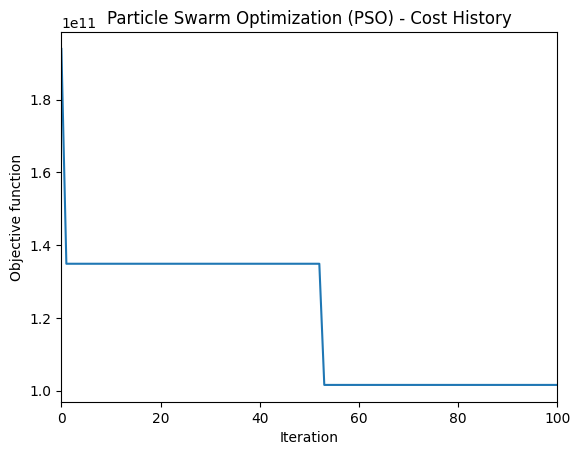

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
                              
Melhor partícula: 427097437892.2774


In [269]:
# Plotar gráfico de densidade da otimização
plt.figure()
plt.plot(optimizer.cost_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization (PSO) - Cost History')
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("                              ")
print("Melhor partícula:", pbest_cost[0])

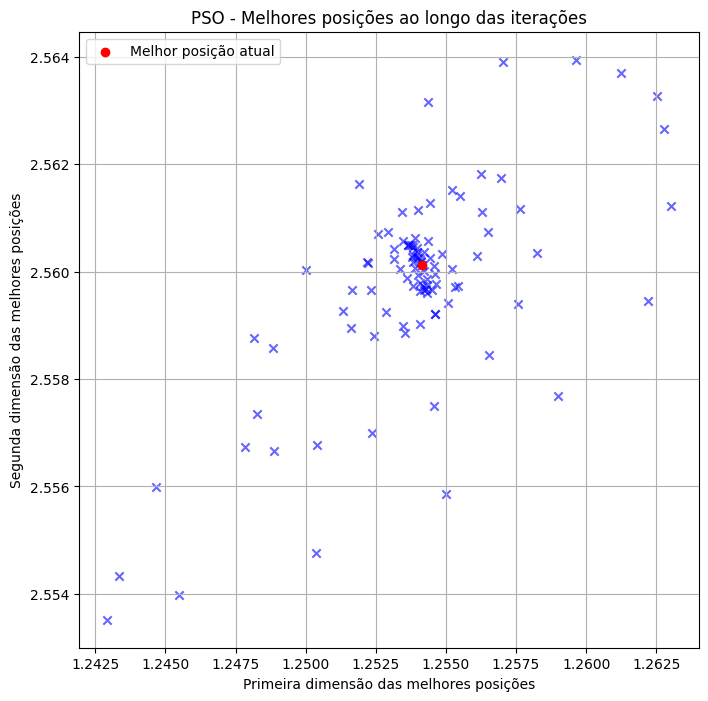

In [270]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker='x', c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()